## Before we dig deeper into the genre — Why it matters?

In [63]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, year, explode, lower, size, array_contains
from pymongo import MongoClient
import findspark
import pandas as pd

In [64]:
import sys
print(sys.executable)

C:\Users\user\anaconda3\python.exe


In [65]:
client = MongoClient("localhost", 27017)
db = client["Movies"]

genre_col = db["Genre"]
movies_col = db["Movies"]
spotify_col = db["spotify"]

In [66]:
import os

os.environ["SPARK_HOME"] = "D:\\columbia\\cu spring 2025\\managing data\\project\\spark-3.5.5-bin-hadoop3\\spark-3.5.5-bin-hadoop3"
os.environ["HADOOP_HOME"] = "D:\\columbia\\cu spring 2025\\managing data\\project\\spark-3.5.5-bin-hadoop3\\spark-3.5.5-bin-hadoop3"

os.environ["JAVA_HOME"] = "C:\\Program Files\\Eclipse Adoptium\\jdk-11.0.27.6-hotspot"

os.environ["PATH"] = f"{os.environ['SPARK_HOME']}\\bin;{os.environ['JAVA_HOME']}\\bin;" + os.environ["PATH"]

os.environ["PYSPARK_PYTHON"] = "C:\\Users\\user\\anaconda3\\python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"] = "C:\\Users\\user\\anaconda3\\python.exe"

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MySparkApp") \
    .master("local[*]") \
    .getOrCreate()

print(spark.version)

3.5.5


In [67]:
spark

In [68]:
spark._jvm.org.mongodb.spark.MongoSpark

In [69]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MySparkMongoApp") \
    .master("local[*]") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:10.2.0") \
    .config("spark.mongodb.read.connection.uri", "mongodb://localhost:27017/Movies.Movies") \
    .config("spark.mongodb.write.connection.uri", "mongodb://localhost:27017/Movies.Movies") \
    .getOrCreate()


In [70]:
import json
movies = movies_col.find(
    {},
    {"_id": 0, "title": 1, "vote_count": 1, "vote_average": 1})                                            
movies = list(movies)
movies_df = pd.DataFrame(movies)
movies_df

,title,vote_average,vote_count
0,Cinderella,7.043,6821
1,Broken Arrow,6.700,200
2,Sunset Boulevard,8.300,2663
3,Rashomon,8.071,2291
4,All About Eve,8.082,1570
...,...,...,...
927118,El perita,0.000,0
927119,Special Delivery,0.000,0
927120,Alexandria Through My Eyes,0.000,0
927121,Cinzas da Floresta,0.000,0


## New PySpark Genre and Time Series Analysis: Recommendations improvements

In [71]:
from pyspark.sql import SparkSession
import os

os.environ["SPARK_HOME"] = "D:\\columbia\\cu spring 2025\\managing data\\project\\spark-3.5.5-bin-hadoop3\\spark-3.5.5-bin-hadoop3"
os.environ["HADOOP_HOME"] = "D:\\columbia\\cu spring 2025\\managing data\\project\\spark-3.5.5-bin-hadoop3\\spark-3.5.5-bin-hadoop3"

os.environ["JAVA_HOME"] = "C:\\Program Files\\Eclipse Adoptium\\jdk-11.0.27.6-hotspot"

os.environ["PATH"] = f"{os.environ['SPARK_HOME']}\\bin;{os.environ['JAVA_HOME']}\\bin;" + os.environ["PATH"]

os.environ["PYSPARK_PYTHON"] = "C:\\Users\\user\\anaconda3\\python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"] = "C:\\Users\\user\\anaconda3\\python.exe"

mongo_connector_jar = "D:\\columbia\\cu spring 2025\\managing data\\project\\mongo-spark-connector_2.12-10.2.1.jar"

spark = SparkSession.builder \
    .appName("MySparkMongoApp") \
    .master("local[*]") \
    .config("spark.jars", mongo_connector_jar) \
    .config("spark.mongodb.read.connection.uri", "mongodb://localhost:27017/Movies.Movies") \
    .config("spark.mongodb.write.connection.uri", "mongodb://localhost:27017/Movies.Movies") \
    .getOrCreate()

In [72]:
print(spark.version)

3.5.5


In [73]:
print(movies_df.columns)

Index(['title', 'vote_average', 'vote_count'], dtype='object')


In [74]:
print(movies_df.head())

              title  vote_average  vote_count
0        Cinderella         7.043        6821
1      Broken Arrow         6.700         200
2  Sunset Boulevard         8.300        2663
3          Rashomon         8.071        2291
4     All About Eve         8.082        1570


In [75]:
for doc in genre_col.find().limit(5):
    print(doc)

{'_id': ObjectId('680198268b8e545f8f08b902'), 'genres': [{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 80, 'name': 'Crime'}, {'id': 99, 'name': 'Documentary'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 14, 'name': 'Fantasy'}, {'id': 36, 'name': 'History'}, {'id': 27, 'name': 'Horror'}, {'id': 10402, 'name': 'Music'}, {'id': 9648, 'name': 'Mystery'}, {'id': 10749, 'name': 'Romance'}, {'id': 878, 'name': 'Science Fiction'}, {'id': 10770, 'name': 'TV Movie'}, {'id': 53, 'name': 'Thriller'}, {'id': 10752, 'name': 'War'}, {'id': 37, 'name': 'Western'}]}


In [76]:
genre_doc = genre_col.find_one({}, {"_id": 0, "genres": 1})

genres_df = pd.DataFrame(genre_doc["genres"])
genres_df

,id,name
0,28,Action
1,12,Adventure
2,16,Animation
3,35,Comedy
4,80,Crime
5,99,Documentary
6,18,Drama
7,10751,Family
8,14,Fantasy
9,36,History


In [77]:
import pandas as pd
from pymongo import MongoClient

client = MongoClient("localhost", 27017)
db = client["Movies"]
movies_col = db["Movies"]
genre_col = db["Genre"]

genre_doc = genre_col.find_one({}, {"_id": 0, "genres": 1})
genre_map = {g["id"]: g["name"] for g in genre_doc["genres"]}


In [78]:
movies = movies_col.find({}, {"_id": 0, "title": 1, "vote_average": 1, "release_date": 1, "genre_ids": 1})
movies_df = pd.DataFrame(list(movies))

movies_df["release_date"] = pd.to_datetime(movies_df["release_date"], errors='coerce')
movies_df = movies_df.dropna(subset=["release_date", "vote_average", "genre_ids"])
movies_df = movies_df[movies_df["release_date"].dt.year >= 1970]

In [79]:
expanded_rows = []
for _, row in movies_df.iterrows():
    for gid in row["genre_ids"]:
        genre_name = genre_map.get(gid)
        if genre_name:
            expanded_rows.append({
                "title": row["title"],
                "vote_average": row["vote_average"],
                "release_year": row["release_date"].year,
                "genre": genre_name
            })
expanded_df = pd.DataFrame(expanded_rows)

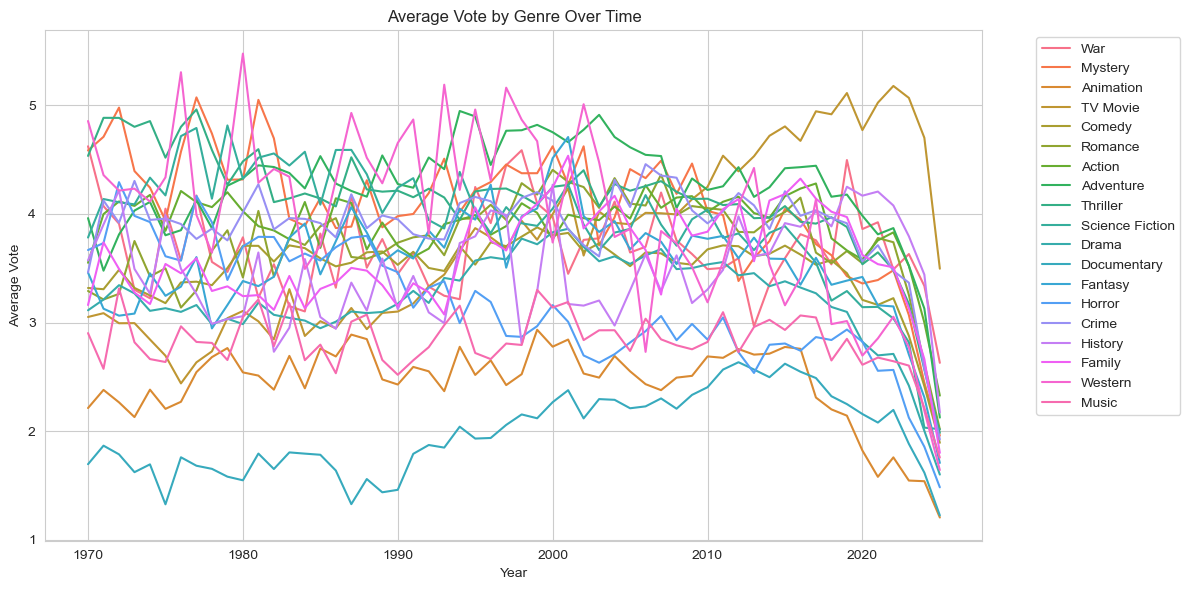

In [80]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg

spark = SparkSession.builder.appName("GenreTimeSeries").getOrCreate()
spark_df = spark.createDataFrame(expanded_df)

# Compute average vote per genre per year
result = spark_df.groupBy("genre", "release_year").agg(avg("vote_average").alias("avg_vote"))

# Convert back to Pandas for plotting
plot_df = result.toPandas()

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_df, x="release_year", y="avg_vote", hue="genre")
plt.title("Average Vote by Genre Over Time")
plt.xlabel("Year")
plt.ylabel("Average Vote")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [81]:
full_movies = list(movies_col.find({}, {"title": 1, "release_date": 1, "vote_average": 1, "genre_ids": 1}))
movies_df = pd.DataFrame(full_movies)

In [82]:
movies_df["release_date"] = pd.to_datetime(movies_df["release_date"], errors='coerce')
movies_df = movies_df.dropna(subset=["release_date", "vote_average", "genre_ids"])
movies_df = movies_df[
    (movies_df["release_date"].dt.year >= 1970) &
    (movies_df["release_date"].dt.year <= 1979)
]

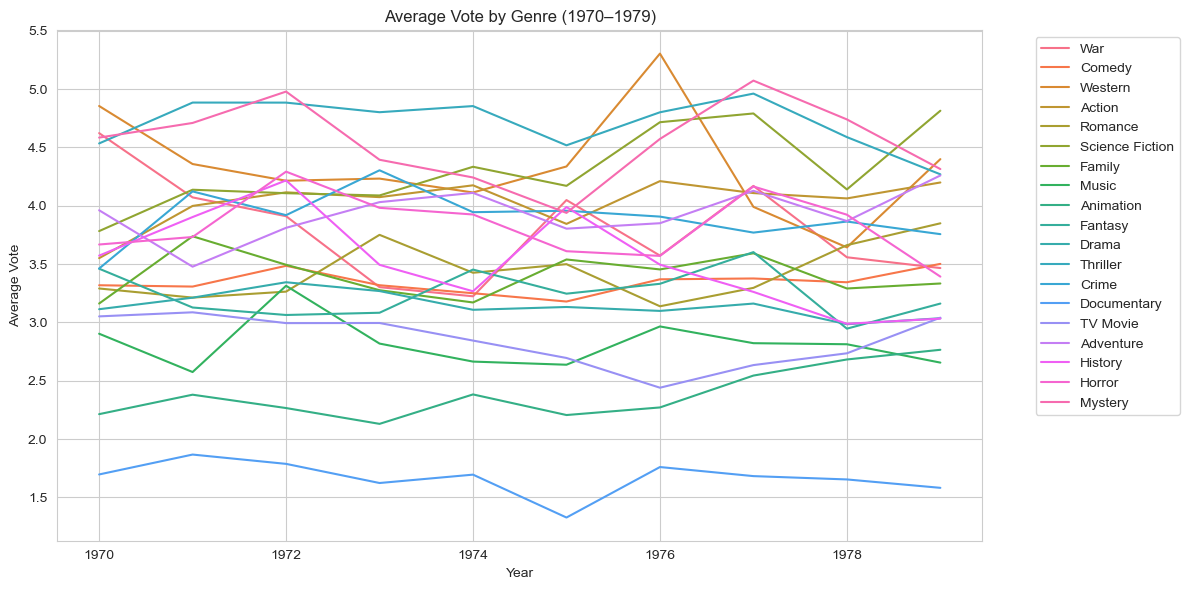

In [92]:
# check on panda plot first
expanded_rows = []
for _, row in movies_df.iterrows():
    for gid in row["genre_ids"]:
        genre_name = genre_map.get(gid)
        if genre_name:
            expanded_rows.append({
                "title": row["title"],
                "vote_average": row["vote_average"],
                "release_year": row["release_date"].year,
                "genre": genre_name
            })
expanded_df = pd.DataFrame(expanded_rows)


spark_df = spark.createDataFrame(expanded_df)

result = spark_df.groupBy("genre", "release_year").agg(avg("vote_average").alias("avg_vote"))

plot_df = result.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_df, x="release_year", y="avg_vote", hue="genre")
plt.title("Average Vote by Genre (1970–1979)")
plt.xlabel("Year")
plt.ylabel("Average Vote")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [85]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, explode, array, lit
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("GenreTimeSeries").getOrCreate()

allowed_genres = ["Science Fiction", "Fantasy", "Action", "Adventure", "Animation", 
                  "Crime", "Drama", "Comedy", "Horror", "Mystery", "History"]

In [86]:
#check pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, to_date
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder.appName("GenreTimeSeries").getOrCreate()

print("Type of expanded_df:", type(expanded_df))

expanded_df_spark = spark.createDataFrame(expanded_df)

print("PySpark DataFrame Schema:")
expanded_df_spark.printSchema()
print("Sample data:")
expanded_df_spark.show(5)

Type of expanded_df: <class 'pandas.core.frame.DataFrame'>
PySpark DataFrame Schema:
root
 |-- title: string (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- release_year: long (nullable = true)
 |-- genre: string (nullable = true)

Sample data:
+--------------------+------------+------------+---------+
|               title|vote_average|release_year|    genre|
+--------------------+------------+------------+---------+
|      The Aristocats|       7.286|        1970|Animation|
|      The Aristocats|       7.286|        1970|   Comedy|
|      The Aristocats|       7.286|        1970|   Family|
|      The Aristocats|       7.286|        1970|Adventure|
|Beneath the Plane...|       6.139|        1970|Adventure|
+--------------------+------------+------------+---------+
only showing top 5 rows



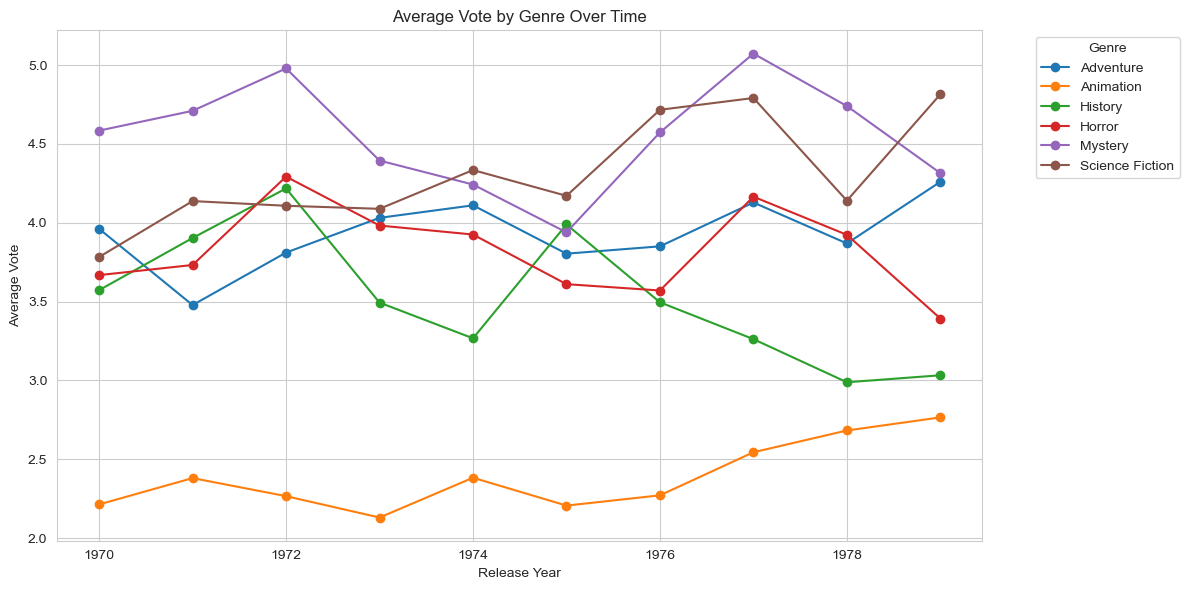

In [87]:
#reduce genre numbers (noise)
allowed_genres = ["Science Fiction", "Adventure", "Animation", "Horror", "Mystery", "History"]

filtered_df = expanded_df_spark.filter(col('genre').isin(allowed_genres))

result_df = filtered_df.groupBy('genre', 'release_year').agg({'vote_average': 'avg'})

result_df = result_df.withColumnRenamed("avg(vote_average)", "avg_vote")

result_pd = result_df.toPandas()

pivot_df = result_pd.pivot_table(index='release_year', columns='genre', values='avg_vote')

plt.figure(figsize=(12, 6))
pivot_df.plot(kind='line', marker='o', ax=plt.gca())

plt.title('Average Vote by Genre Over Time')
plt.xlabel('Release Year')
plt.ylabel('Average Vote')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Final version

C:\Users\user\AppData\Local\Temp\ipykernel_20112\2298452961.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(genre_avgs.index, rotation=45, ha='right')


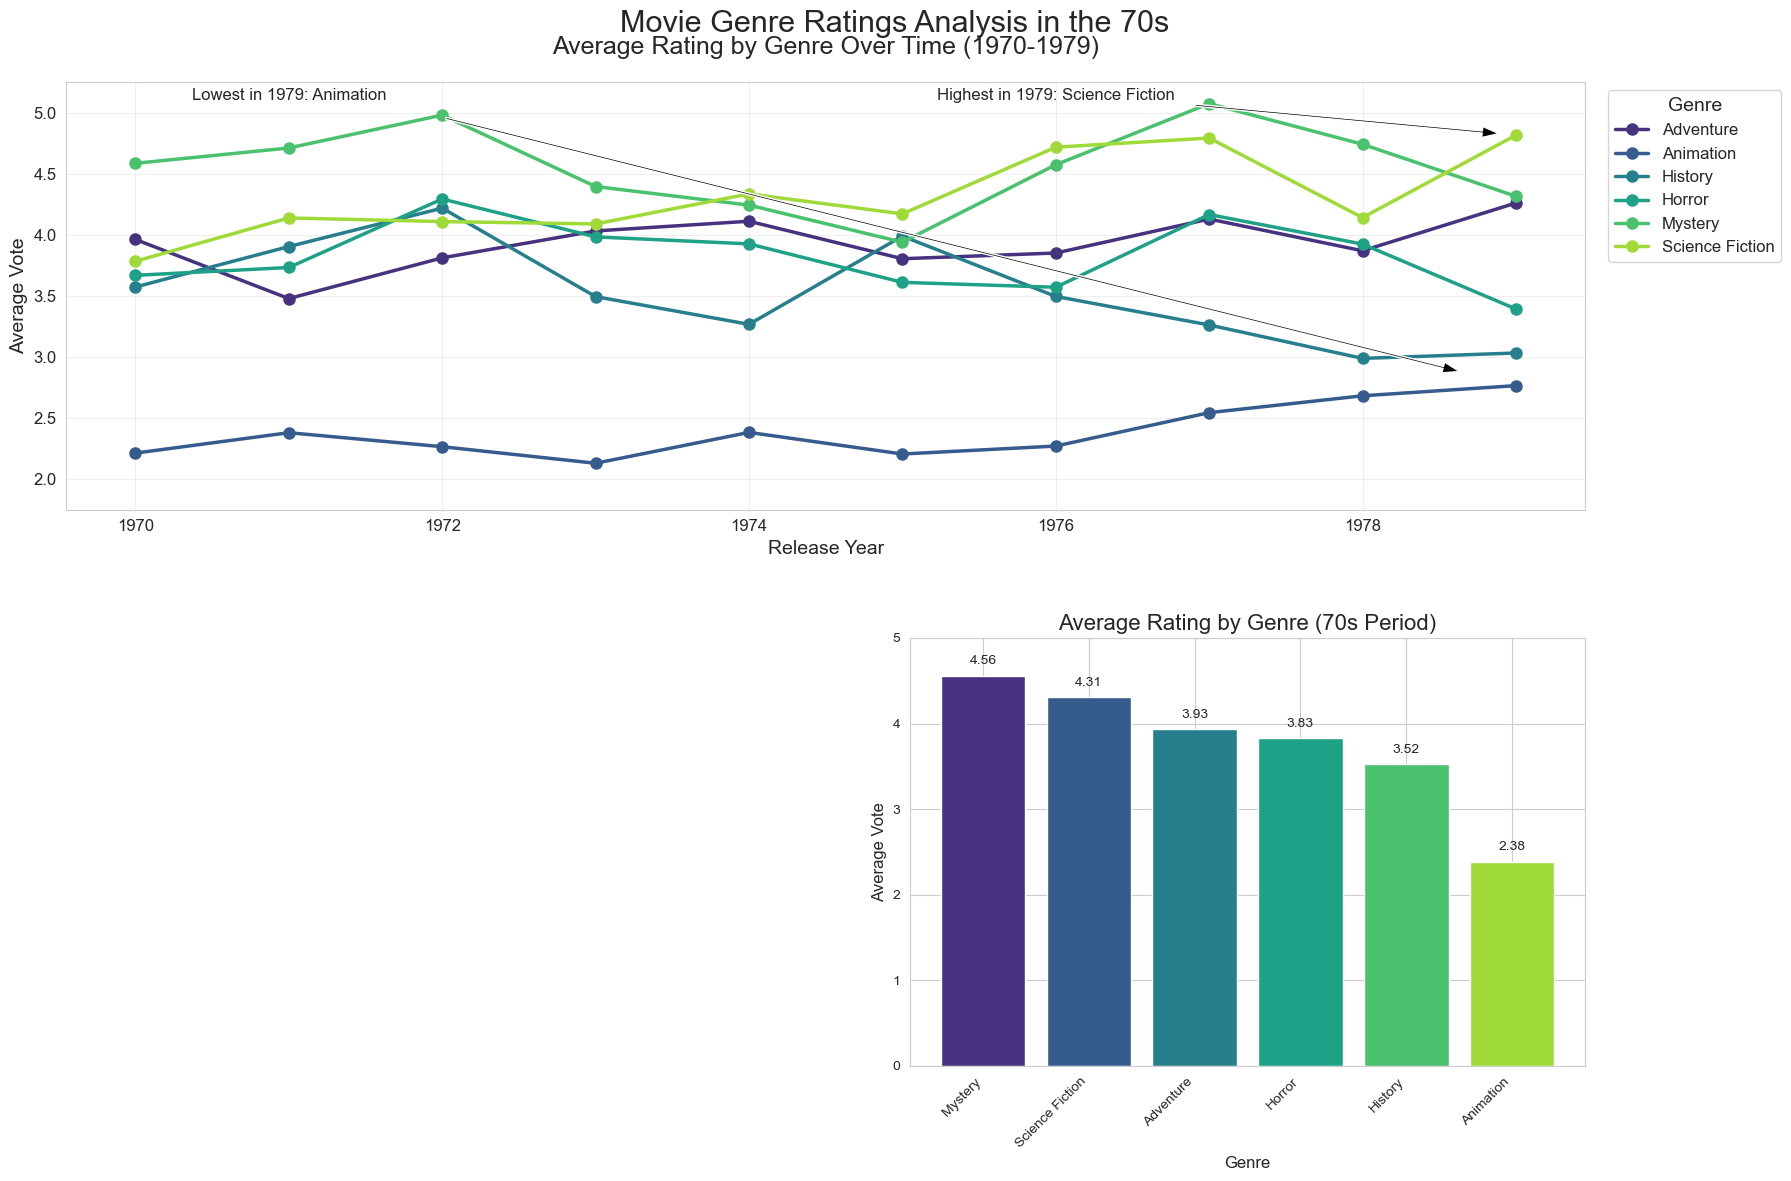

<Figure size 640x480 with 0 Axes>

In [89]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

fig = plt.figure(figsize=(18, 12))

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
palette = sns.color_palette("viridis", len(pivot_df.columns))

for i, genre in enumerate(pivot_df.columns):
    ax1.plot(pivot_df.index, pivot_df[genre], marker='o', linewidth=2.5, 
             markersize=8, label=genre, color=palette[i])

ax1.set_title('Average Rating by Genre Over Time (1970-1979)', fontsize=18, pad=20)
ax1.set_xlabel('Release Year', fontsize=14)
ax1.set_ylabel('Average Vote', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(title='Genre', title_fontsize=14, fontsize=12, bbox_to_anchor=(1.01, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(1.75, 5.25)

best_genre = pivot_df.iloc[-1].idxmax()
worst_genre = pivot_df.iloc[-1].idxmin()
most_improved = (pivot_df.iloc[-1] - pivot_df.iloc[0]).idxmax()

y_pos = 5.1
ax1.annotate(f"Highest in 1979: {best_genre}", 
             xy=(1979, pivot_df[best_genre].iloc[-1]),
             xytext=(1976, y_pos),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             fontsize=12, ha='center')

ax1.annotate(f"Lowest in 1979: {worst_genre}", 
             xy=(1979, pivot_df[worst_genre].iloc[-1]),
             xytext=(1971, y_pos),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             fontsize=12, ha='center')

ax3 = plt.subplot2grid((2, 2), (1, 1))
genre_avgs = pivot_df.mean()
genre_avgs = genre_avgs.sort_values(ascending=False)

bars = ax3.bar(genre_avgs.index, genre_avgs.values, color=palette)
ax3.set_title('Average Rating by Genre (70s Period)', fontsize=16)
ax3.set_xlabel('Genre', fontsize=12)
ax3.set_ylabel('Average Vote', fontsize=12)
ax3.set_ylim(0, 5)
ax3.set_xticklabels(genre_avgs.index, rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.3, wspace=0.25)
fig.suptitle('Movie Genre Ratings Analysis in the 70s', fontsize=22, y=0.98)
plt.show()

plt.savefig('genre_analysis.png', dpi=300, bbox_inches='tight')

###### Clean look

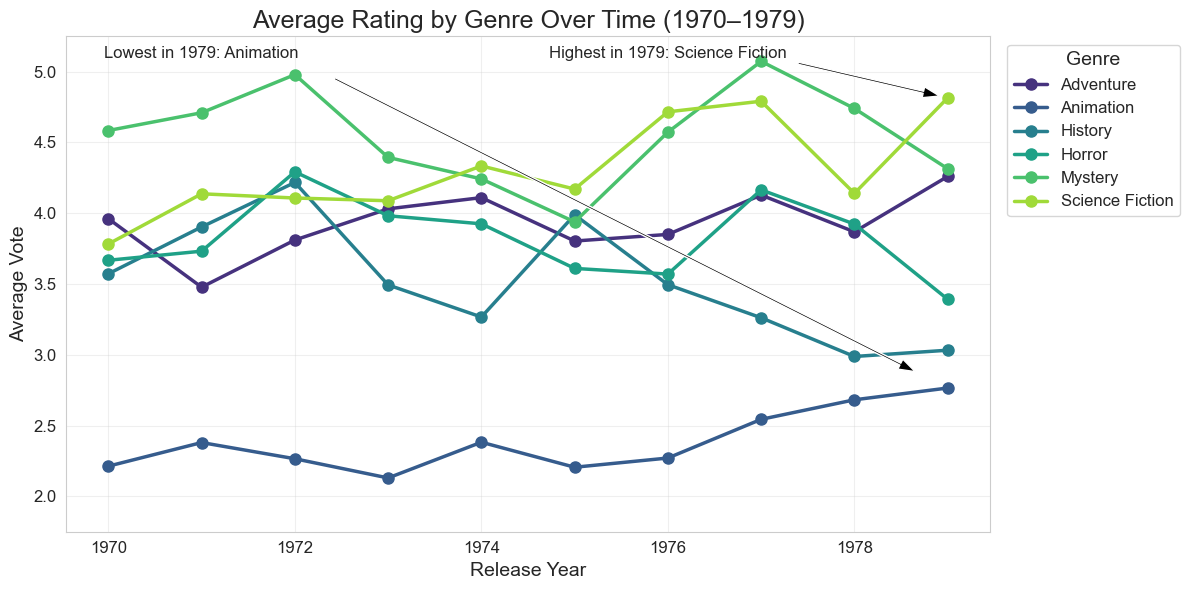

In [90]:
plt.figure(figsize=(12, 6))
palette = sns.color_palette("viridis", len(pivot_df.columns))

for i, genre in enumerate(pivot_df.columns):
    plt.plot(pivot_df.index, pivot_df[genre], marker='o', linewidth=2.5, 
             markersize=8, label=genre, color=palette[i])

plt.title('Average Rating by Genre Over Time (1970–1979)', fontsize=18)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Average Vote', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(1.75, 5.25)
plt.legend(title='Genre', fontsize=12, title_fontsize=14, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True, alpha=0.3)

best_genre = pivot_df.iloc[-1].idxmax()
worst_genre = pivot_df.iloc[-1].idxmin()
y_pos = 5.1
plt.annotate(f"Highest in 1979: {best_genre}", 
             xy=(1979, pivot_df[best_genre].iloc[-1]),
             xytext=(1976, y_pos),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             fontsize=12, ha='center')

plt.annotate(f"Lowest in 1979: {worst_genre}", 
             xy=(1979, pivot_df[worst_genre].iloc[-1]),
             xytext=(1971, y_pos),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             fontsize=12, ha='center')

plt.tight_layout()
plt.show()


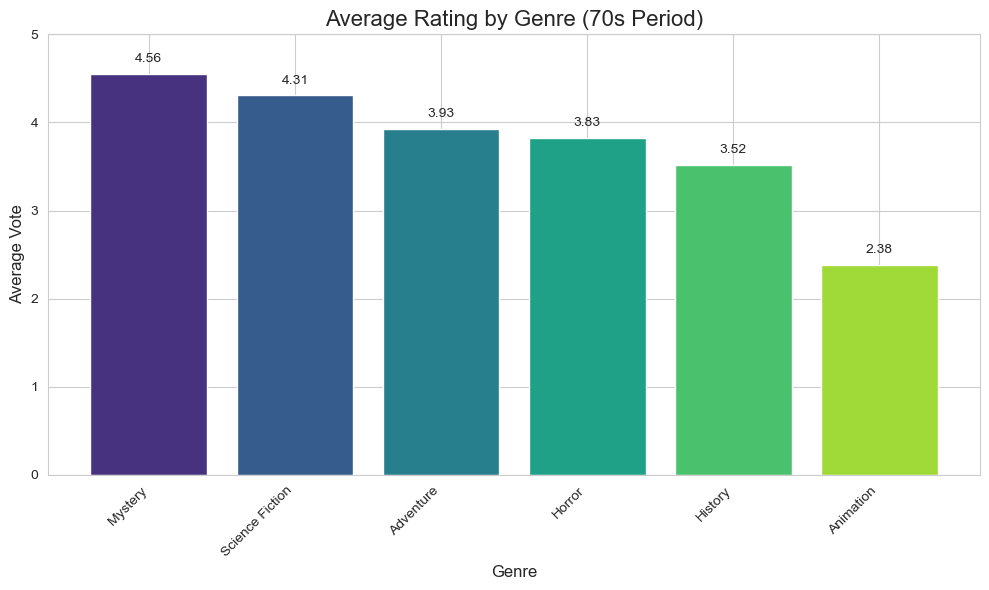

In [91]:
plt.figure(figsize=(10, 6))
genre_avgs = pivot_df.mean().sort_values(ascending=False)
palette = sns.color_palette("viridis", len(genre_avgs))

bars = plt.bar(genre_avgs.index, genre_avgs.values, color=palette)
plt.title('Average Rating by Genre (70s Period)', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Vote', fontsize=12)
plt.ylim(0, 5)
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
